In [14]:
import pandas as pd
from data_prepare import zero_to_mean, zero_to_nan

df = pd.read_csv("./data/diabetes.csv")

target = "Outcome"
labels = df[target]
df = df.drop(columns=[target, "Pregnancies"])

num_cols = df.columns # "X"
non_zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

non_zero_pipeline = Pipeline([
    ('impute_zero_to_nan', FunctionTransformer(zero_to_nan)),
    ('imputer', SimpleImputer(strategy='mean')),
])

pre_imputation = ColumnTransformer(
    transformers=[
        ('non_zero_clean', non_zero_pipeline, non_zero_cols),
    ],
    remainder='passthrough' # tudo que não for non_zero_cols passa sem mexer
)

def boost_glucose(X):
    X[:, 0] *= 2  # Assume que Glucose está na coluna 1
    return X

def boost_insulin(X):
    X[:, 3] *= 2  # Assume que Insulin está na coluna 3
    return X

boost_glucose_transformer = FunctionTransformer(boost_glucose)
boost_insulin_transformer = FunctionTransformer(boost_insulin)

preprocessor = Pipeline([
    ('pre_clean', pre_imputation),
    ('minMax', MinMaxScaler()),
    ('boost_glucose', boost_glucose_transformer),
    ('boost_insulin', boost_insulin_transformer),
])

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def stratify(df: pd.DataFrame, target: pd.DataFrame):
    train_set, test_set, train_labels, test_labels = train_test_split(
        df,
        target,
        test_size = 0.20,
        random_state = 43,
        stratify=target,
    )

    return train_set, train_labels, test_set, test_labels

def prepare_train(df: pd.DataFrame):
    prepared_data = preprocessor.fit_transform(df)

    df_transformed = pd.DataFrame(
        prepared_data,
        columns=num_cols,
        index=df.index,
    )

    return df_transformed

def prepare_predict(df: pd.DataFrame, all_feature_names: list):
    prepared_data = preprocessor.transform(df)
    df_transformed = pd.DataFrame(
        prepared_data,
        columns=all_feature_names,
        index=df.index
    )

    return df_transformed

def model_exc(
        model,
        train_prepared: pd.DataFrame,
        train_labels: pd.DataFrame,
        test_set: pd.DataFrame,
        test_labels: pd.DataFrame,
        cols: list,
):
    model.fit(train_prepared, train_labels)

    test_prepared = prepare_predict(test_set, cols)

    predictions = model.predict_proba(test_prepared)[:, 1]
    threshold = 0.25
    y_pred_custom = (predictions >= threshold).astype(int)

    results = evaluate(test_labels, y_pred_custom)

    return results

def evaluate(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred), # prever negativos
        'recall': recall_score(y_true, y_pred), # prever positivos
        'f1_score': f1_score(y_true, y_pred) # equilíbrio precisão vs recall
    }

In [17]:
train_set, train_labels, test_set, test_labels = stratify(df, labels)
train_prepared = prepare_train(train_set)

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=25, learning_rate=0.4, max_depth=1, random_state=42)

In [19]:
model_exc(
    model,
    train_prepared,
    train_labels,
    test_set,
    test_labels,
    num_cols,
)

{'accuracy': 0.7597402597402597,
 'precision': 0.6024096385542169,
 'recall': 0.9259259259259259,
 'f1_score': 0.7299270072992701}

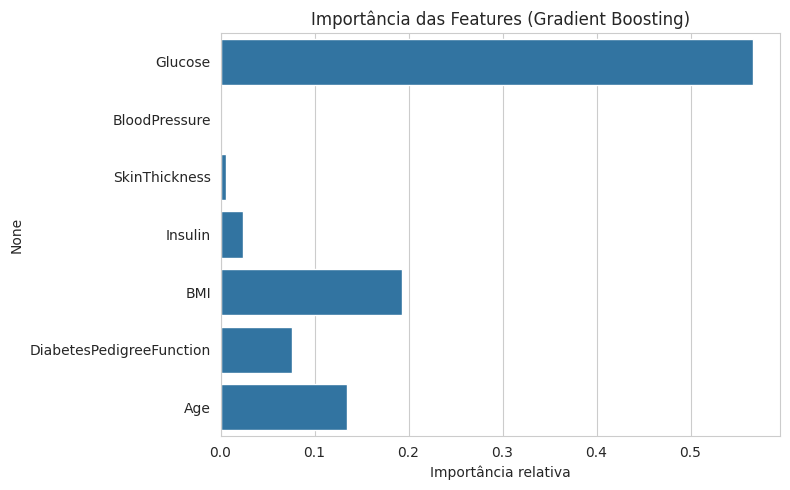

In [20]:
model.fit(train_prepared, train_labels)

importances = model.feature_importances_

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=num_cols)
plt.title("Importância das Features (Gradient Boosting)")
plt.xlabel("Importância relativa")
plt.tight_layout()
plt.show()

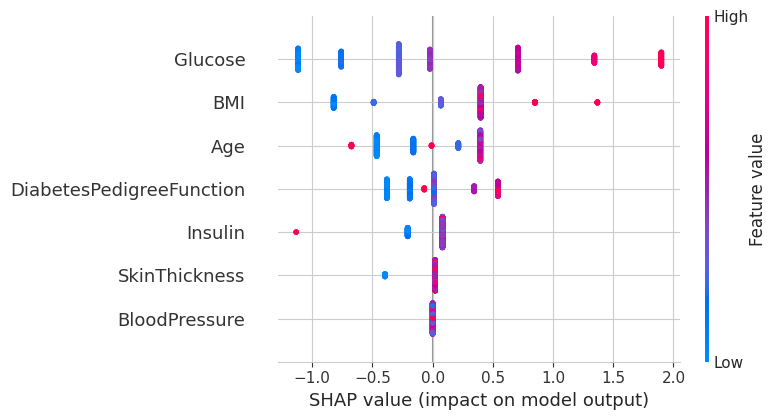

In [21]:
import shap

explainer = shap.Explainer(model, train_prepared)
shap_values = explainer(train_prepared)

shap.summary_plot(shap_values, train_prepared, feature_names=num_cols)

## Considerações finais

- Foram feitos muitos testes com diferentes algorítimos validando as métricas em validação cruzada e outras aplicações de tunning do modelo, tratando dados com valor zero, aplicando escalonamento dos dados e até implementando um "boost" em variáveis com maior correlação, mesmo assim o "precision" dificilmente ultrapassa 60%. Como a validação cruzada mostrava um desvio padrão muito pequeno em relação aos folds (aprox. 0.05), a conclusão é que o dataset é pequeno e chegou no seu limite.

- Reduzir o threshold para 0.25 aumentou o recall (prever mais positivos) porém não tem uma boa precision (pode dar falsos positivos), mas no âmbito médico, é melhor manter um "false positivo" e pedir para que a pessoa realize mais exames, do que dar um falso negativo.

- Mesmo acertando 92% dos casos positivos, a palavra final sempre será do médico.